# Shared Data Context

The intent of this notebook is to provide examples of how data scientists can use object storage, and more specifically, Ceph object storage, much in the same way they are accustomed to interacting with Amazon Simple Storage Service (S3). This is made possible because Ceph's object storage gateway offers excellent fidelity with the modalities of Amazon S3.

# Working with Boto

Boto is an integrated interface to current and future infrastructural services offered by Amazon Web Services. Amoung the services it provides interfaces for is Amazon S3. For lightweight analysis of data using python tools like numpy or pandas, it is handy to interact with data stored in object storage using pure python. This is where Boto shines. 

In [ ]:
import os
import boto3

s3 = boto3.client('s3','us-east-1', endpoint_url= os.environ['S3_ENDPOINT'],
                       aws_access_key_id = os.environ['ACCESSKEY'],
                       aws_secret_access_key = os.environ['SECRETKEY'])


Creating a bucket, uploading and object (put), and listing the bucket.

In [ ]:
s3.create_bucket(Bucket='ceph-bucket')
s3.put_object(Bucket='ceph-bucket',Key='object',Body='data')
for key in s3.list_objects(Bucket='ceph-bucket')['Contents']:
    print(key['Key'])

# Working with Spark

First we need to create a pyspark context with either with Spark locally in the notebook pod, or with the Spark master endpoint of a cluster provisioned with the [radanalytics](https://github.com/radanalyticsio/spark-operator/)  operator for Apache Spark.

In [ ]:
import os
import pyspark

from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master("local[3]").getOrCreate()

In [ ]:
hadoopConf=spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.endpoint", os.environ['S3_ENDPOINT'])
hadoopConf.set("fs.s3a.access.key", os.environ['ACCESSKEY'])
hadoopConf.set("fs.s3a.secret.key", os.environ['SECRETKEY'])
hadoopConf.set("fs.s3a.path.style.access", "true")
hadoopConf.set("fs.s3a.connection.ssl.enabled", "false")

In [ ]:
import socket
spark.range(100, numPartitions=100).rdd.map(lambda x: socket.gethostname()).distinct().collect()

In [ ]:
df0 = spark.read.text("s3a://ceph-bucket/object")

In [ ]:
df0

# Working with a Hybrid Data Context

As of Hadoop 2.8, S3A supports per bucket configuration. This is very powerful. It allows us to have a distinct S3A configuration per bucket, with a different endpoint and different set of credentials. With this I can use a single Spark command to read files from a bucket in the public cloud (Amazon S3) into a data frame, then turn around and write that dataframe into a bucket that exists in the Ceph service running in the local OpenShift cluster.

In [ ]:
hadoopConf=spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.bucket.bd-dist.endpoint", "s3.amazonaws.com")
hadoopConf.set("fs.s3a.bucket.bd-dist.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")

__Public to Private ETL__

Simply read tab separated data from a bucket in Amazon S3 and write it back out to a bucket in our Ceph object service.

In [ ]:
spark.read.csv("s3a://bd-dist/trip_report.tsv",sep="\t").write.csv("s3a://ceph-bucket/trip_report.tsv",sep="\t")

Extract all JSON files from a bucket prefix (pseudo directory) in Amazon S3 and write them back out to a bucket in our Ceph object service with the same bucket prefix.

In [ ]:
spark.read.option("multiline", True).option("mode", "PERMISSIVE").json("s3a://bd-dist/kube-metrics").repartition(76).write.option("compression", "bzip2").json("s3a://ceph-bucket/kube-metrics")

# Working with SparkSQL

Load Prometheus data set from the Ceph bucket into a data frame.

In [ ]:
jsonFile = spark.read.json("s3a://ceph-bucket/kube-metrics")

__Import statistics libraries__

In [ ]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

__Display schema of files__

In [ ]:
print('Display schema:')
jsonFile.printSchema()

__Query the JSON data using filters__

In [ ]:
#Register the created SchemaRDD as a temporary table.
jsonFile.registerTempTable("kubelet_docker_operations_latency_microseconds")

#Filter the results into a data frame
data = spark.sql("SELECT values, metric.operation_type FROM kubelet_docker_operations_latency_microseconds WHERE metric.quantile='0.9' AND metric.hostname='free-stg-master-03fb6'")

data.show()

In [ ]:
data_pd = data.toPandas()

OP_TYPE = 'list_images'

df2 = pd.DataFrame(columns = ['utc_timestamp','value', 'operation_type'])
#df2 ='
for op in set(data_pd['operation_type']):
    dict_raw = data_pd[data_pd['operation_type'] == op]['values']
    list_raw = []
    for key in dict_raw.keys():
        list_raw.extend(dict_raw[key])
    temp_frame = pd.DataFrame(list_raw, columns = ['utc_timestamp','value'])
    temp_frame['operation_type'] = op
    
    df2 = df2.append(temp_frame)


df2 = df2[df2['value'] != 'NaN']

df2['value'] = df2['value'].apply(lambda a: int(a))

df2['timestamp'] = df2['utc_timestamp'].apply(lambda a : datetime.fromtimestamp(int(a)))

df2.head()

__ Objective - Verify Above Alerts __

Store timestamp with data

In [ ]:
df2.reset_index(inplace =True)

del df2['index']

df2['operation_type'].unique()

Segregate the values by operation type in separate variables as Series

In [ ]:
def get_filtered_op_frame(op_type):
    temp = df2[df2.operation_type == op_type]
    temp = temp.sort_values(by='timestamp')
    return temp

operation_type_value = {}
for temp in list(df2.operation_type.unique()):
    operation_type_value[temp] = get_filtered_op_frame(temp)['value']

__Descriptive Stats__

It refers to the portion of statistics dedicated to summarizing a total population

_Mean_

Arithmetic average of a range of values or quantities, computed by dividing the total of all values by the number of values.

In [ ]:
for temp in operation_type_value.keys():
    print("Mean of: ",temp, " - ", np.mean(operation_type_value[temp]))

_Variance_

In the same way that the mean is used to describe the central tendency, variance is intended to describe the spread. The xi – μ is called the “deviation from the mean”, making the variance the squared deviation multiplied by 1 over the number of samples. This is why the square root of the variance, σ, is called the standard deviation.

In [ ]:
for temp in operation_type_value.keys():
    print("Variance of: ",temp, " - ", np.var(operation_type_value[temp]))

_Standard Deviation_

Standard deviation (SD, also represented by the Greek letter sigma σ or the Latin letter s) is a measure that is used to quantify the amount of variation or dispersion of a set of data values.[1] A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.

In [ ]:
for temp in operation_type_value.keys():
    print("Standard Deviation of: ",temp, " - ", np.std(operation_type_value[temp]))

_Median_

Denotes value or quantity lying at the midpoint of a frequency distribution of observed values or quantities, such that there is an equal probability of falling above or below it. Simply put, it is the middle value in the list of numbers. The median is a better choice when the indicator can be affected by some outliers.

In [ ]:
for temp in operation_type_value.keys():
    print("Median of: ",temp, " - ", np.median(operation_type_value[temp]))

__Histogram__

The most common representation of a distribution is a histogram, which is a graph that shows the frequency or probability of each value. Plots will be generated by operation type

We will use Seaborn module for this. __Kernel Density Estimation__ * will be added for smoothing.

* In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample.
* The kernel density estimate may be less familiar, but it can be a useful tool for plotting the shape of a distribution. Like the histogram, the KDE plots encodes the density of observations on one axis with height along the other axis:

In [ ]:
sns.set(color_codes = True)

for temp in operation_type_value.keys():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,12))
    sns.distplot(get_filtered_op_frame(temp)['value'], kde=True, ax=ax[0], axlabel= temp)
    sns.distplot(np.log(get_filtered_op_frame(temp)['value']), kde=True, ax=ax[1], axlabel = "Log transformed "+ temp)
    fig.show()


__Understanding__

They are all log normals, cause value will always be greater than 0

In [ ]:
df2.columns

__Box-Whisker__

Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.

Log normalisation is required because, for different operations, values seems to be in very different scales

In [ ]:
df_whisker =  df2
df_whisker['log_transformed_value'] = np.log(df2['value'])

In [ ]:
df_whisker.head()

In [ ]:
plt.figure(figsize=(20,15))
ax = sns.boxplot(x="operation_type", y="log_transformed_value", hue="operation_type", data=df_whisker)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

__Finding trend in time series, if there any__

Trend means, if over time values have increasing or decreasing pattern. In this example we see that there is a trend of a slow and steady increase followed by a sharp drop.

In [ ]:
operation_type_value.keys()

for temp in operation_type_value.keys():
    #fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,12))
    temp_frame = get_filtered_op_frame(temp)
    temp_frame = temp_frame.set_index(temp_frame.timestamp)
    temp_frame = temp_frame[['log_transformed_value']]
    temp_frame.plot(figsize=(15,12),title=temp)

# Working with Local TensorFlow

__Access the data using Spark__

In [4]:
feedbackFile = spark.read.csv("s3a://ceph-bucket/trip_report.tsv",sep="\t", header=True)

Alternatively, we can load the trip report from the original sample TSV object in Amazon S3.

In [ ]:
feedbackFile = spark.read.csv("s3a://bd-dist/trip_report.tsv",sep="\t", header=True)

__Convert the data to a Pandas data frame__

In [5]:
import re

import pandas as pd
import matplotlib.pyplot as plt

df = feedbackFile.toPandas()

df.head()

,Timestamp,Your Name,Number of customers/potentials/attendees:,Primary Audience Engaged,Primary Sales Conversation,"Key People (Presenters, Attendees, Organizers, etc)",Outcome,Full Notes,Trip Name,Email Address,Action Items,Date,Highlights,Lowlights,Learnings,Trip Region,Number of Days,Estimated Cost (USD),Product Mix,_c19
0,1/24/2017 16:46:47,Bryanty Pople,35,Customer,Vertical Solution,Emera Ambrogioli,Successful,None,Yodel,eambrogioli0@constantcontact.com,Organized leading edge analyzer,1/24/2017,Cras in purus eu magna vulputate luctus. Cum s...,In quis justo. Maecenas rhoncus aliquam lacus....,In quis justo. Maecenas rhoncus aliquam lacus....,NA,1,200,None,None
1,2/1/2017 12:09:48,Bryanty Pople,1,Event,Solution (ISBU),Rurik Ossipenko,Unsuccessful,None,Tazzy,rossipenko1@angelfire.com,Digitized bifurcated focus group,1/16/2017,Nullam sit amet turpis elementum ligula vehicu...,Phasellus sit amet erat. Nulla tempus. Vivamus...,"Sed sagittis. Nam congue, risus semper porta v...",NA,5,200,None,None
2,2/3/2017 9:16:38,Bryanty Pople,3,Field,Solution (ISBU),Sheryl Gayter,Unsuccessful,None,Browsecat,sgayter2@friendfeed.com,Down-sized discrete Graphic Interface,1/31/2017,"Mauris enim leo, rhoncus sed, vestibulum sit a...",Etiam vel augue. Vestibulum rutrum rutrum nequ...,In sagittis dui vel nisl. Duis ac nibh. Fusce ...,EMEA,3,200,None,None
3,2/5/2017 13:41:22,Bryanty Pople,30,Engineering,RHEL,Minda Djurdjevic,Successful,None,Oodoo,mdjurdjevic3@goo.gl,Expanded bifurcated info-mediaries,1/25/2017,Duis at velit eu est congue elementum. In hac ...,Mauris sit amet eros. Suspendisse accumsan tor...,Nullam porttitor lacus at turpis. Donec posuer...,EMEA,2,2000,None,None
4,2/5/2017 13:47:19,Bryanty Pople,1500,Event,Containers,Sondra Heasley,Successful,None,Thoughtworks,sheasley4@google.co.uk,Stand-alone uniform throughput,1/27/2017,"Sed sagittis. Nam congue, risus semper porta v...","Nulla neque libero, convallis eget, eleifend l...","Proin leo odio, porttitor id, consequat in, co...",EMEA,3,1000,None,None


# Visualize the data

__Types of trip outcomes by field representative__

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


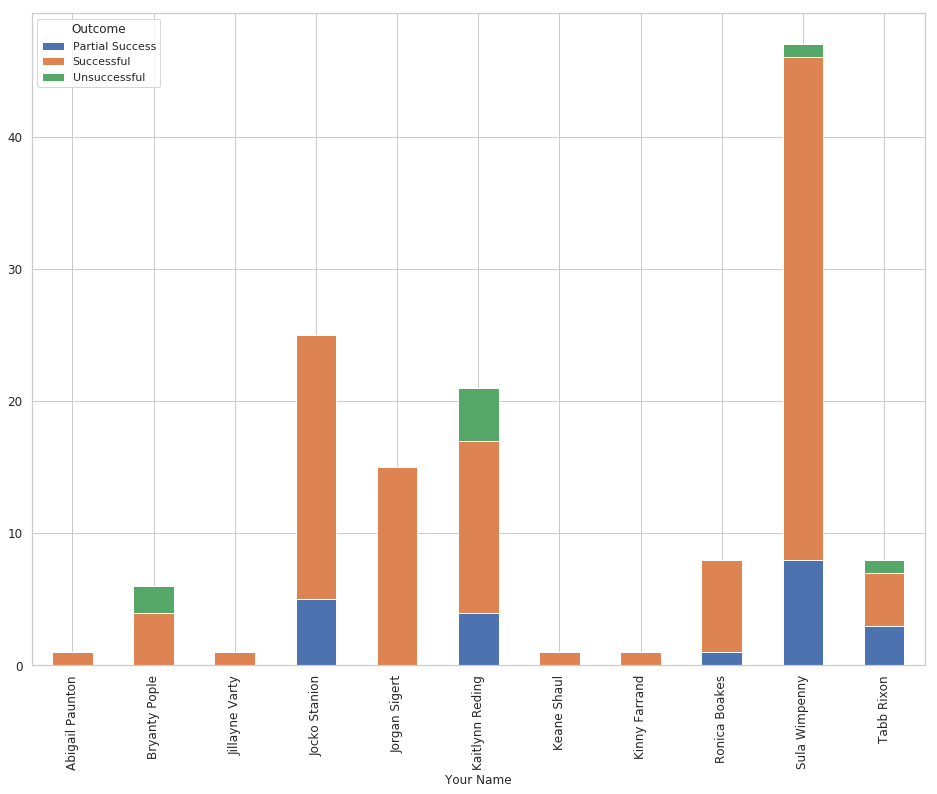

In [6]:
import numpy as np
np.random.seed(sum(map(ord, "categorical")))

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

outcome_dict = {'Successful':0,'Partial Success':1,'Unsuccessful':2 }

df_vis = df[['Your Name', 'Outcome']]
df_vis['outcome_numeric'] = df_vis['Outcome'].apply(lambda a:outcome_dict[a])



outcome_cross_table = pd.crosstab(index=df_vis["Your Name"], 
                          columns=df_vis["Outcome"])


outcome_cross_table.plot(kind="bar", 
                 figsize=(16,12),
                 stacked=True,fontsize=12)
plt.show();

__Types of outcomes by event type__

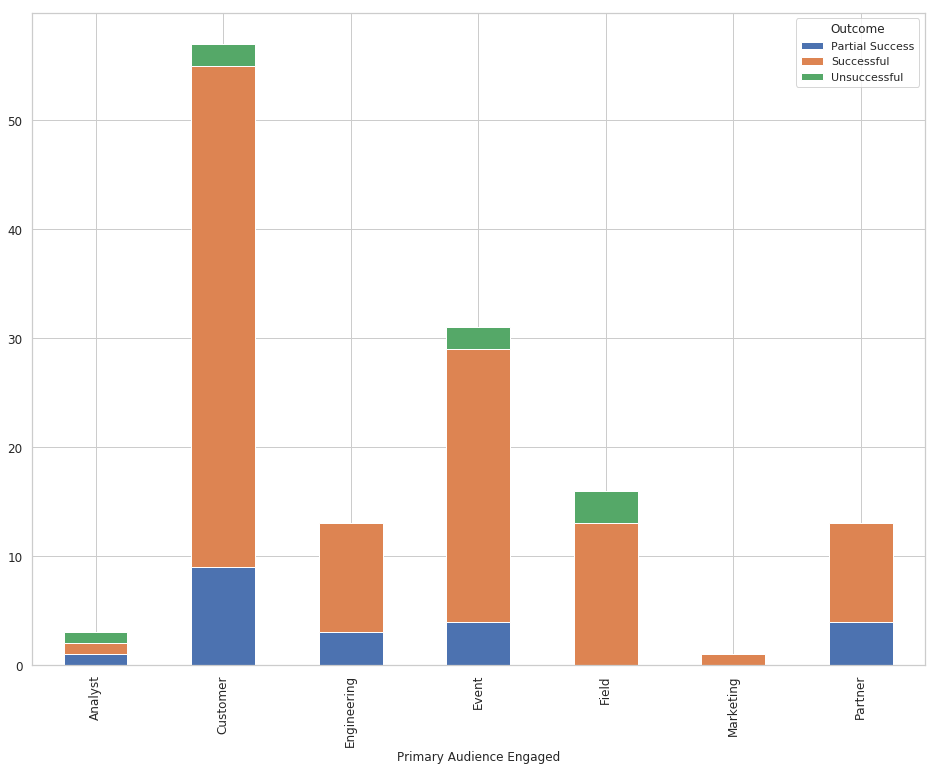

In [7]:
event_type_cross_table = pd.crosstab(index=df["Primary Audience Engaged"], 
                          columns=df["Outcome"])

event_type_cross_table.plot(kind="bar", 
                 figsize=(16,12),
                 stacked=True,fontsize=12)
plt.show();

# Now convert "Highlights" data to prepare for training the model

In [8]:
df['Highlights'] = df['Highlights'].astype(str)

df[['Highlights','Outcome']].head(20)

,Highlights,Outcome
0,Cras in purus eu magna vulputate luctus. Cum s...,Successful
1,Nullam sit amet turpis elementum ligula vehicu...,Unsuccessful
2,"Mauris enim leo, rhoncus sed, vestibulum sit a...",Unsuccessful
3,Duis at velit eu est congue elementum. In hac ...,Successful
4,"Sed sagittis. Nam congue, risus semper porta v...",Successful
5,"Integer pede justo, lacinia eget, tincidunt eg...",Successful
6,Suspendisse potenti. Nullam porttitor lacus at...,Successful
7,In blandit ultrices enim.,Partial Success
8,Mauris ullamcorper purus sit amet nulla. Quisq...,Successful
9,"Cras mi pede, malesuada in, imperdiet et, comm...",Partial Success


In [9]:
df_outcome = df[['Highlights','Outcome']]

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

grouped_highlights = pd.DataFrame(df_outcome.groupby('Outcome')['Highlights'].apply(lambda x: "%s" % ' '.join(x)))

grouped_highlights['Outcome'] = list(grouped_highlights.index.get_values())
grouped_highlights.reset_index(drop=True, inplace=True)

grouped_highlights['Highlights'] = grouped_highlights['Highlights'].astype(str)

df['Highlights'] = df['Highlights'].apply(lambda a: a.lower())

df_success = df[df['Outcome'] == 'Successful']
df_unsuccess = df[df['Outcome'] == 'Unsuccessful']
df_part_success = df[df['Outcome'] == 'Partial Success']

__Import additional Machine Learning libraries__

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

__Separating train and test data. Taking successful and unsuccessful separately__

In [11]:
df_failure = df_part_success.append(df_unsuccess, ignore_index= True)

df_failure['Outcome'] = 'Unsuccessful'

test_hold_out = 0.1

#### Success

train = df_success[ : -int(test_hold_out * len(df_success))]
test = df_success[-int(test_hold_out * len(df_success)) : ]

#### Failure

train = train.append(df_failure[ : -int(test_hold_out * len(df_failure))])
test = test.append(df_failure[-int(test_hold_out * len(df_failure)) : ])


train = train.sample(frac = 1)
train['type'] = "Train"
test['type'] = "Test"

train = train.append(test)

train.reset_index(drop=True,inplace=True)

Y = pd.get_dummies(train['Outcome']).values

test_index_list = list(train[train['type'] == 'Test'].index)

test_index_list

[122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133]

# Use the HIGHLIGHTS field for sentiment analysis

__max_features__ = Vocabulary size, its a hyper parameter

*Tokenizer creates vectors from text, mainly works like a dictionary id in total vocabulary, returns list of integers, where every integer acts like an index 

In [12]:
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train['Highlights'].values)
X_highlights = tokenizer.texts_to_sequences(train['Highlights'].values)
X_highlights = pad_sequences(X_highlights)

__Creating the network layer by layer__

First layer is word embedding layer, second layer is LSTM based RNN, and third layer is Softmax activation layer, due to categorical outcome

In [33]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_highlights.shape[1]))
model.add(Dropout(0.05))
model.add(LSTM(lstm_out, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 75, 128)           1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 196)               254800    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 394       
Total params: 1,535,194
Trainable params: 1,535,194
Non-trainable params: 0
_________________________________________________________________
None


__Separating train and test data__

In [34]:
X_highlights_train = X_highlights[0:test_index_list[0]]
Y_highlights_train = Y[0:test_index_list[0]]

X_highlights_test = X_highlights[test_index_list[0]:]
Y_highlights_test = Y[test_index_list[0]:]

__Running the model__

Batch size and number of epoch can be changed as optimisation

In [35]:
batch_size = 20
model.fit(X_highlights_train, Y_highlights_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
 - 4s - loss: 0.6679 - acc: 0.7377
Epoch 2/10
 - 2s - loss: 0.5659 - acc: 0.7787
Epoch 3/10
 - 2s - loss: 0.5206 - acc: 0.7787
Epoch 4/10
 - 2s - loss: 0.5015 - acc: 0.7787
Epoch 5/10
 - 2s - loss: 0.4561 - acc: 0.7787
Epoch 6/10
 - 2s - loss: 0.4252 - acc: 0.7787
Epoch 7/10
 - 2s - loss: 0.3984 - acc: 0.8033
Epoch 8/10
 - 2s - loss: 0.3476 - acc: 0.8443
Epoch 9/10
 - 2s - loss: 0.3122 - acc: 0.8689
Epoch 10/10
 - 2s - loss: 0.2794 - acc: 0.9180


__Printing test data accuracy__

In [36]:
score,accuracy = model.evaluate(X_highlights_test, Y_highlights_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (accuracy))

score: 1.05
accuracy: 0.58


# Save the model, tokenizer and feature dimension and store them in Ceph

In [37]:
model.save("./model")

import pickle

with open('./tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

feature_dimension = X_highlights_train.shape[1]
with open('./feature_dimension.pickle', 'wb') as handle:
    pickle.dump(feature_dimension, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
import boto3
s3 = boto3.resource('s3')

#Create S3 session for writing manifest file
session = boto3.Session(
    aws_access_key_id = os.environ['ACCESSKEY'],
    aws_secret_access_key = os.environ['SECRETKEY']
)

s3 = session.resource('s3', endpoint_url=os.environ['S3_ENDPOINT'], verify=False)

# Upload the model to S3
s3.meta.client.upload_file('./model', 'ceph-bucket', 'models/trip_report_model')

# Upload the tokenizer to S3
s3.meta.client.upload_file('./tokenizer.pickle', 'ceph-bucket', 'models/trip_report_tokenizer.pickle')

# Upload the feature dimension to S3
s3.meta.client.upload_file('./feature_dimension.pickle', 'ceph-bucket', 'models/trip_report_feature_dimension.pickle')

The model has been saved to s3 as binary objects and can be viewed